<a href="https://colab.research.google.com/github/SiLiKhon/HEPStatsSeminar/blob/master/MLFit_OpenData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install probfit

In [0]:
import numpy as np
import pandas as pd
import probfit
import iminuit
import matplotlib.pyplot as plt
%matplotlib inline

## Let's get some real data!

We'll work with events with pairs of oppositely charged muons, and
we'll try to select Z->mu mu decays and estimate the Z-boson mass.

*For more details on the dataset see: http://opendata.cern.ch/record/545*

In [0]:
data = pd.read_csv('http://opendata.cern.ch/record/545/files/Dimuon_DoubleMu.csv')
print("Nuber of events: {}".format(len(data)))
print("Columns are:")
for col in data.columns:
  print("  {}".format(col))

Nuber of events: 100000
Columns are:
  Run
  Event
  type1
  E1
  px1
  py1
  pz1
  pt1
  eta1
  phi1
  Q1
  type2
  E2
  px2
  py2
  pz2
  pt2
  eta2
  phi2
  Q2
  M


So far we are only going to work with the **invariant mass** of the two muons.
Let's plot it:

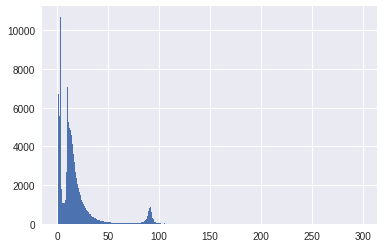

In [0]:
plt.hist(data.M, bins=300);

Hmm, hard to see anything like that. Let's do a log-log plot:

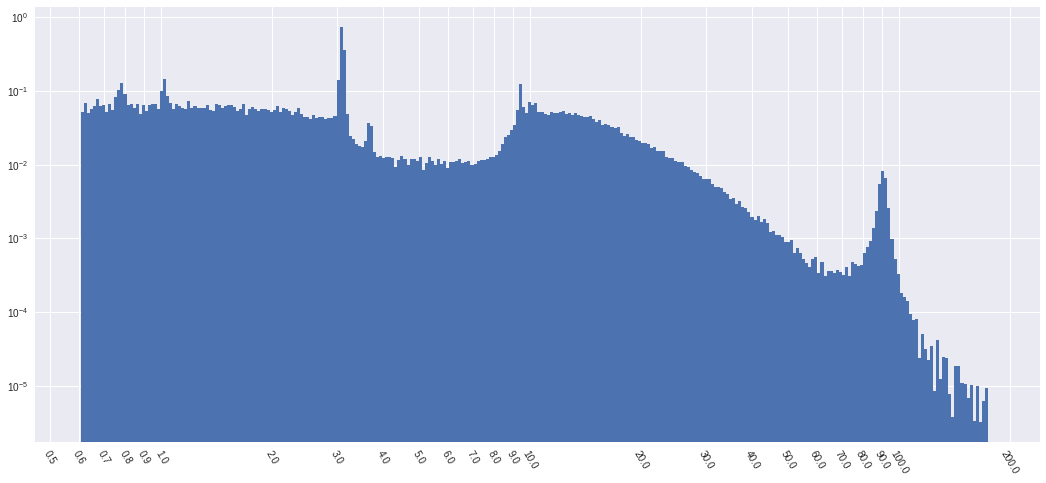

In [0]:
from matplotlib.ticker import FormatStrFormatter, LogLocator

plt.figure(figsize=(18,8))
plt.hist(data.M, bins=np.logspace(-0.5, 5.2, 301, base=np.e), density=True);
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.gca().get_xaxis().set_major_formatter(FormatStrFormatter('%.1f'))
plt.gca().get_xaxis().set_major_locator(LogLocator(subs='all'))
plt.xticks(rotation=-60);

That's better! Can you name all the peaks? :)

OK, we know the rightmost peak is from Z boson. Let's zoom in to it:

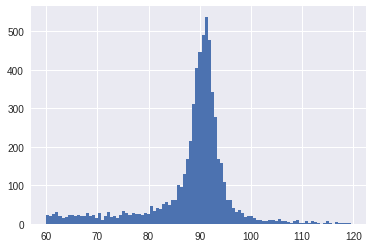

In [0]:
mass_range = (60., 120.)

data = data.loc[(data.M > mass_range[0]) & (data.M < mass_range[1])]
plt.hist(data.M, bins=100);

Now, we'll do the same ML fit as we did before, using the same model:

In [0]:
def SignalPDF(x, mass, sigma):
  return probfit.gaussian(x, mass, sigma)

def BgPDF(x, bg_slope):
  return bg_slope * np.exp(-bg_slope * x)

SignalPDF_n = probfit.Normalized(SignalPDF, mass_range)
BgPDF_n     = probfit.Normalized(BgPDF    , mass_range)

ModelPDF = probfit.AddPdfNorm(SignalPDF_n, BgPDF_n, facname=['fsig'])

In [0]:
likelihood = probfit.UnbinnedLH(ModelPDF, data.M.values)

In [0]:
print(iminuit.describe(likelihood))

['mass', 'sigma', 'bg_slope', 'fsig']


Now it's your turn to specify the initial parameter values, their limits and steps:

In [0]:
init_pars = dict(mass=90.,
                 sigma=5.,
                 bg_slope=1./60,
                 fsig=0.9)

par_limits = dict(limit_mass    =(80, 100),
                  limit_sigma   =( 2,  20),
                  limit_bg_slope=(1./500, 1./10),
                  limit_fsig    =(0.,  1.))

par_errors = dict(error_mass    =5.,
                  error_sigma   =1.,
                  error_bg_slope=0.05,
                  error_fsig    =0.05,
                 )

minuit = iminuit.Minuit(likelihood, **init_pars, **par_limits, **par_errors)

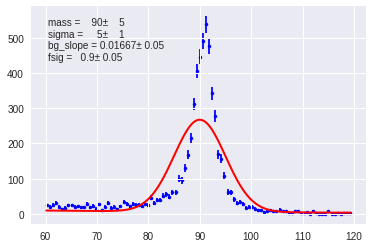

In [0]:
likelihood.draw(minuit=minuit);

In [0]:
minuit.migrad();

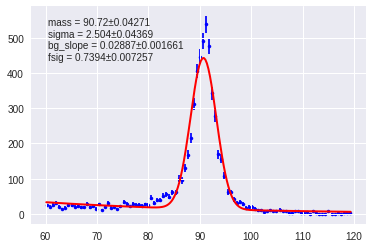

In [0]:
likelihood.draw(minuit=minuit);

It's easy to see that this fit is not perfect: our model does not seem to describe the data very well.
Any ideas how our model can be modified to improve this?

Suggestions:
  - Use sum of two gaussians with **same mean**. You can do this by creating two wrappers with same name for the 'mean' parameter, but different names for 'sigma':
  ```python
    def Signal_G1(x, mass, sigma1):
      return probfit.gaussian(x, mass, sigma1)
    def Signal_G2(x, mass, sigma2):
      return probfit.gaussian(x, mass, sigma2)
    signal = probfit.AddPdfNorm(Signal_G1, Signal_G2, facname=['G1_fraction'])
    ####   In this example I'm skipping normalization; please don't forget to add it!
  ```
  - Use [CrystalBall function](https://en.wikipedia.org/wiki/Crystal_Ball_function). It's already implemented in `probfit` as `probfit.crystalball`
  - Use a sum of gaussian and CrystalBall

In [0]:
def sig1(x, mass, sigma, a, n):
  return probfit.crystalball(x, a, n, mass, sigma)
sig1 = probfit.Normalized(sig1, mass_range)

def sig2(x, mass, sigma, d_sigma):
  return probfit.gaussian(x, mass, sigma + d_sigma)
sig2 = probfit.Normalized(sig2, mass_range)

sig = probfit.AddPdfNorm(sig2, sig1, facname=['gaus_frac'])

def bg(x, bg_slope):
  return bg_slope * np.exp(-bg_slope * x)

bg = probfit.Normalized(bg, mass_range)

model_pdf = probfit.AddPdfNorm(sig, bg, facname=['fsig'])

In [0]:
likelihood = probfit.UnbinnedLH(model_pdf, data.M.values)
print(iminuit.describe(likelihood))

['mass', 'sigma', 'd_sigma', 'a', 'n', 'gaus_frac', 'bg_slope', 'fsig']


In [0]:
init_pars = dict(mass=90,
                 sigma=5,
                 d_sigma=15,
                 a=1.,
                 n=2.,
                 gaus_frac=0.2,
                 bg_slope=1./60,
                 fsig=0.9)

par_limits = dict(limit_mass=(80, 100),
                  limit_sigma=(1, 15),
                  limit_d_sigma=(1, 80),
                  limit_a=(0.05, 5),
                  limit_n=(0.1, 10.),
                  limit_gaus_frac=(0., 1.),
                  limit_bg_slope=(1./10000, 3./10),
                  limit_fsig=(0., 1.))

par_errors = dict(error_mass=5,
                  error_sigma=2,
                  error_d_sigma=10,
                  error_a=0.2,
                  error_n=0.5,
                  error_gaus_frac=0.1,
                  error_bg_slope=0.01,
                  error_fsig=0.05)

minuit = iminuit.Minuit(likelihood, **init_pars, **par_limits, **par_errors)

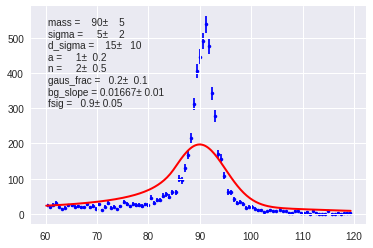

In [0]:
likelihood.draw(minuit=minuit);

In [0]:
minuit.migrad();

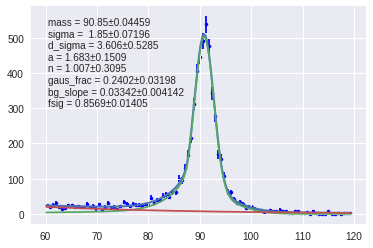

In [0]:
likelihood.draw(minuit=minuit, parts=True);

## Discussion

Using a model with CrystalBall+Gaussian signal PDF I was able to obtain the following value for the Z-boson mass:
$$m_Z=90.85 \pm 0.04\text{ GeV.}$$
Can we write a paper with this result?

Let's first compare it with other measurements. There is a collaboration named [Particle Data Group](https://en.wikipedia.org/wiki/Particle_Data_Group) (PDG); they have a lot of useful HEP material, and they calculate average values from various measurements of different particle parameters.

Probably the easiest way to navigate through their averages is by using their [pdglive website](http://pdglive.lbl.gov/). Let's open it and got to the Z-boson page. Their mass value is:
$$m_Z^{\text{PDG}} = 91.1876 \pm 0.0021\text{ GeV}.$$
Huh! Our value is 8-9 sigmas away!..

### Likelihood error
The error for $m_Z$ that we got was estimated from the likelihood function to be (in my case) 0.04 GeV. This is what's called a **statistical error**, it would be the only error in case the following two assumtions were true:
  - the data we're looking at was produced with exact same probability density function as we used for our likelihood;
  - each measurement in individual events has infinite precision and no bias.
  
Actually, both of these are false. Because of that there's also a **systematic error**.

#### Model systematics
Here is a CMS paper on the Z and W production cross section measurement: http://cdsweb.cern.ch/record/1337017

There's the following plot in that paper:
![CMS Z->mumu with simulated components](https://twiki.cern.ch/twiki/pub/CMSPublic/EWK-10-005/Zmumu_log.png)

This is the invariant mass spectrum from the $\mu^+\mu^-$ events; components from different processes are highlighted.

Have a look at the EWK ('electroweak') component. There's a peaking background in it! This small peak comes from $Z\rightarrow \tau\tau$ decays when each of the $\tau$-leptons has decayed into a muon and neutrinos. Since we don't see the neutrinos, they take some energy away - this shifts the peak to the left from the actual Z-boson mass value.

Taking this background into account would take some effort: you have to know how many background events there are (this depends on relative decay probabilities and on the probabilities to reconstruct them), and you have to know the shape of the distribution (one could run a simulation to obtain this shape).

#### Detector systematics
Invariant mass is calculated from the muon parameters. More precisely, it's calculated from muon momenta. There's an irreducible uncertainty up to which detector can measure the momentum - this can be estimated when the detector is calibrated.